# Extract Absence EEG data from dataset

Extract all the absence EEG data from the dataset, analyse and apply filters. Split into epochs/windows. Export for testing.


In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib qt

import mne
from mne.filter import notch_filter

## Load Data From Dataset


In [115]:
# Set data location
DEV_DATA_FOLDER = "E:/edf/dev"

# Set absence data file names from absence_files.txt
ABSENCE_FILES_NAMES = []
with open(r"processed_data\absence\absence_files.txt", "r") as f:
    for i in f.readlines():
        ABSENCE_FILES_NAMES.append(DEV_DATA_FOLDER + i[:-1])


# Change index to change which absence seizure to load
def import_data(seizure_idx):
    raw = mne.io.read_raw_edf(ABSENCE_FILES_NAMES[seizure_idx])
    print(raw.load_data())
    return raw

In [116]:
seizure_idx = 5
raw = import_data(seizure_idx)

Extracting EDF parameters from E:\edf\dev\02_tcp_le\006\00000675\s002_2006_09_05\00000675_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...
<RawEDF | 00000675_s002_t001.edf, 41 x 311250 (1245.0 s), ~97.4 MB, data loaded>


## Select n Channels


In [117]:
channels = [0, 1, 2, 3, 4]
excl_channels = raw.info["ch_names"][len(channels) :]
raw.drop_channels(
    excl_channels
)  # Drop channels in excl_channels, keep only channels in channels

Measurement date,"September 05, 2006 11:36:02 GMT"
Experimenter,Unknown
Participant,00000675
Digitized points,Not available
Good channels,5 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


## Analyse and Filter Data


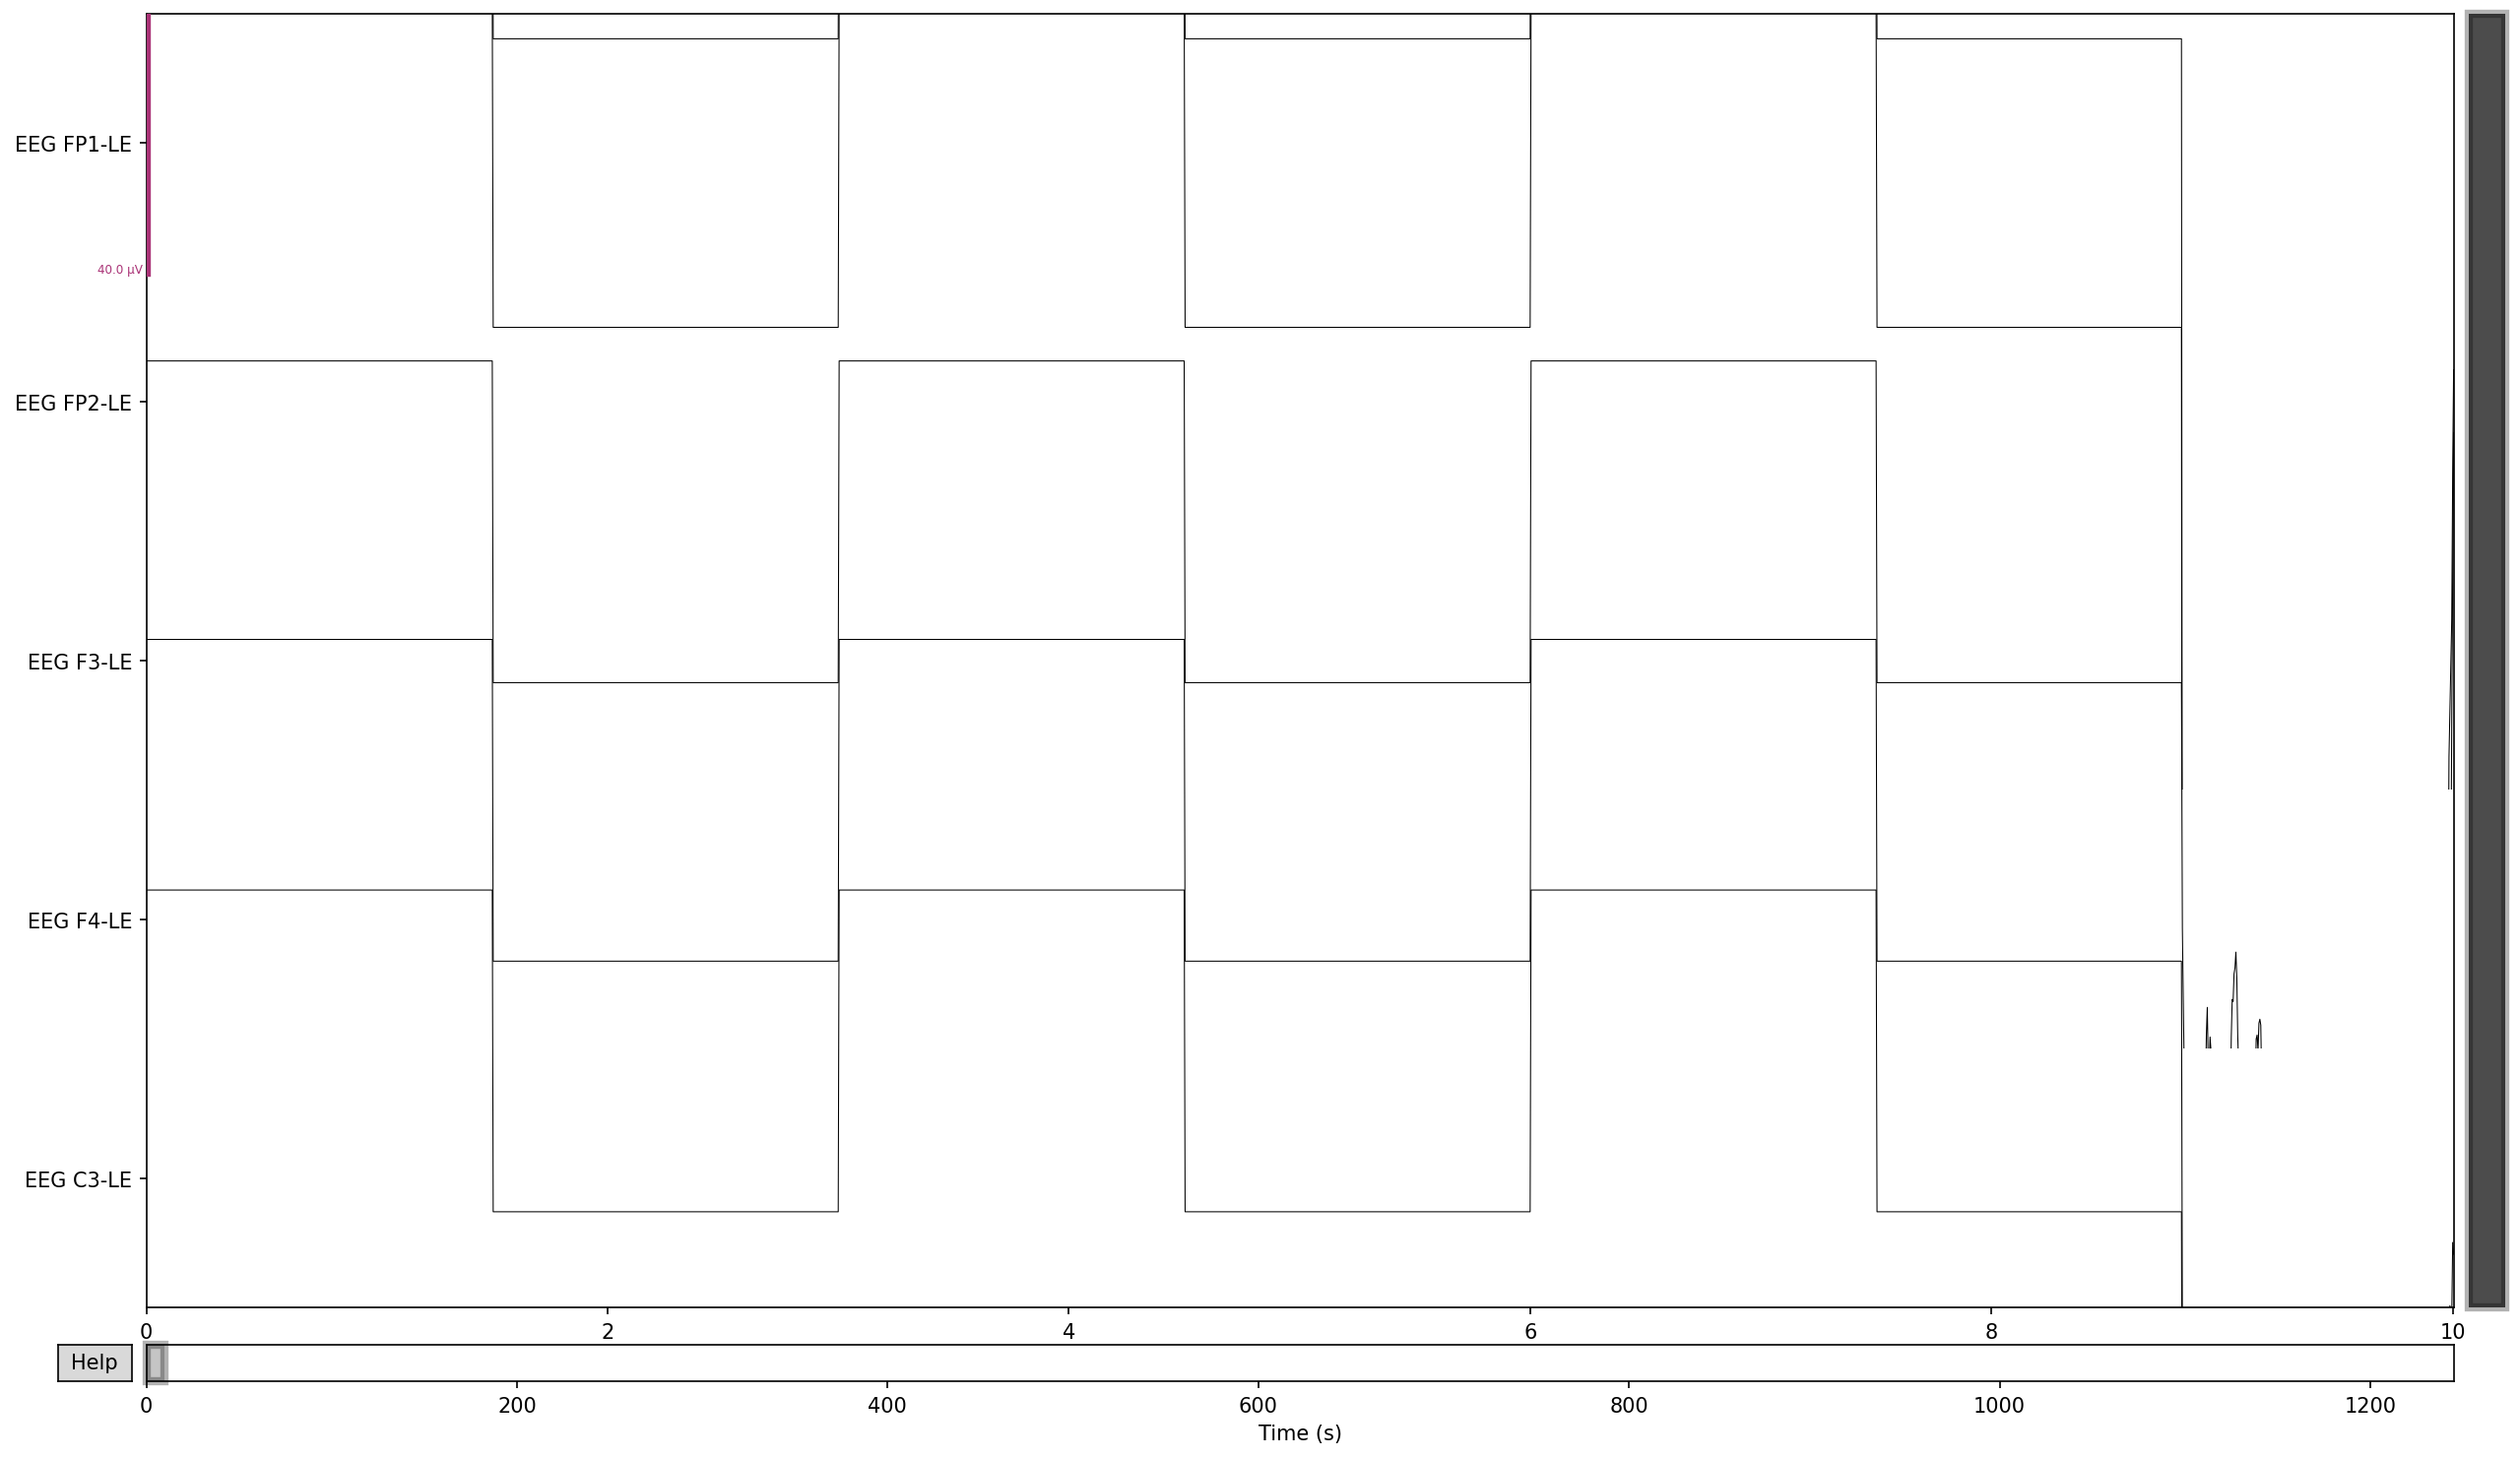

In [118]:
# Plot raw data
raw.plot()

Effective window size : 8.192 (s)


C:\Users\loicl\AppData\Local\Temp\ipykernel_20428\854838781.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


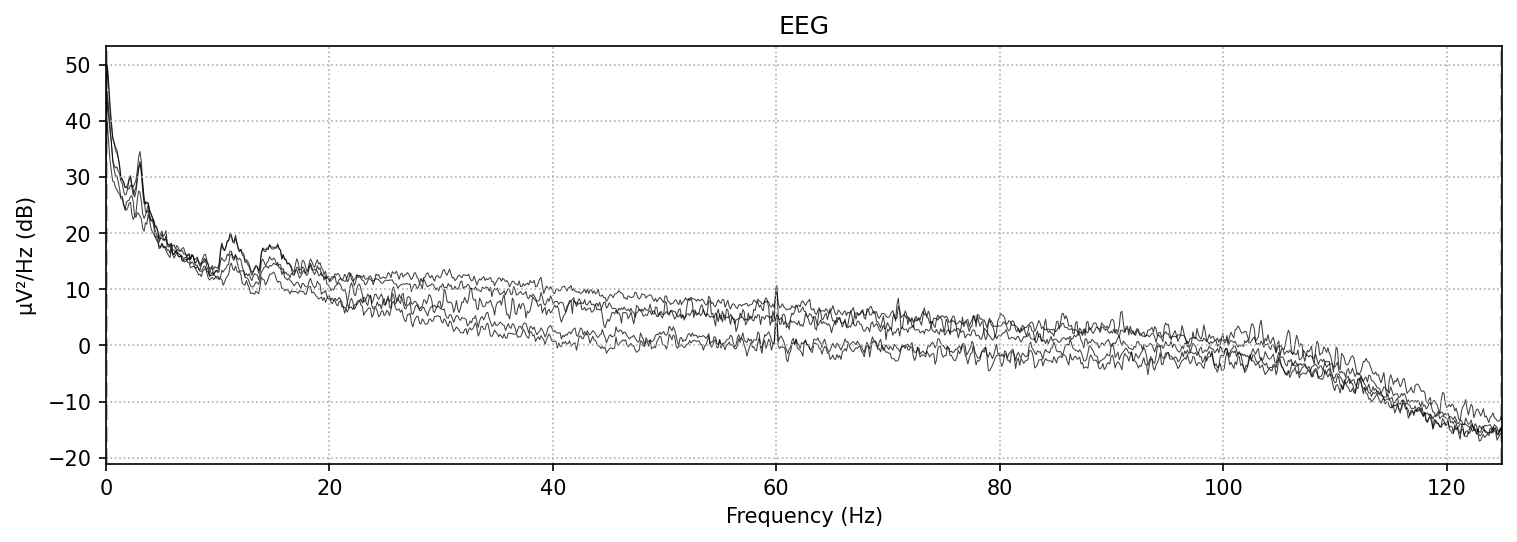

In [119]:
# Plot Power Spectral Density
raw.compute_psd().plot()

In [120]:
raw.notch_filter(60)  # 60 Hz notch filter
raw.filter(None, 90, fir_design="firwin")  # 90 Hz lowpass filter

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 37 sa

Measurement date,"September 05, 2006 11:36:02 GMT"
Experimenter,Unknown
Participant,00000675
Digitized points,Not available
Good channels,5 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,90.00 Hz


## Split into Epochs/Windows


In [121]:
epoch_duration = 4
epoch_overlap = 2
epochs = mne.make_fixed_length_epochs(
    raw, duration=epoch_duration, overlap=epoch_overlap
)

epochs_vector = epochs.get_data()

Not setting metadata
621 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 621 events and 1000 original time points ...
0 bad epochs dropped


## Create Labels


In [122]:
def format_annotations(annotations_file):
    annotations_list = []
    with open(annotations_file, "r") as f:
        for i, v in enumerate(f.readlines()):
            if i >= 2:
                row = v.split(" ")
                row.remove(row[-1])
                annotations_list.append(row)
    return annotations_list

In [123]:
# Import annotations from annotation file
annotations_from_file = format_annotations(
    annotations_file=f"processed_data/absence/annotations/{seizure_idx+1}/00000675_s002_t001.tse"
)
annotations_from_file

[['0.0000', '115.4120', 'bckg'],
 ['115.4120', '119.7120', 'absz'],
 ['119.7120', '155.7120', 'bckg'],
 ['155.7120', '160.6120', 'absz'],
 ['160.6120', '168.2120', 'bckg'],
 ['168.2120', '169.9120', 'absz'],
 ['169.9120', '181.3120', 'bckg'],
 ['181.3120', '185.1120', 'absz'],
 ['185.1120', '205.4120', 'bckg'],
 ['205.4120', '210.2120', 'absz'],
 ['210.2120', '232.1120', 'bckg'],
 ['232.1120', '234.1120', 'absz'],
 ['234.1120', '244.3120', 'bckg'],
 ['244.3120', '246.3120', 'absz'],
 ['246.3120', '251.5120', 'bckg'],
 ['251.5120', '254.3120', 'absz'],
 ['254.3120', '255.2120', 'bckg'],
 ['255.2120', '256.6120', 'absz'],
 ['256.6120', '313.4120', 'bckg'],
 ['313.4120', '319.7120', 'absz'],
 ['319.7120', '554.7680', 'bckg'],
 ['554.7680', '558.9680', 'absz'],
 ['558.9680', '777.1240', 'bckg'],
 ['777.1240', '783.6240', 'absz'],
 ['783.6240', '1025.0633', 'bckg'],
 ['1025.0633', '1028.2120', 'absz'],
 ['1028.2120', '1034.0120', 'bckg'],
 ['1034.0120', '1037.3120', 'absz'],
 ['1037.3120', 

In [124]:
# 0 = no seizure, 1 = absence seizure
def create_labels(raw_edf, annotations):
    data, time = raw_edf.get_data(return_times=True)
    duration_seconds = time[-1]
    events = {}
    for i in range(int(len(time) / 250)):
        for j in annotations:
            if i in range(int(float(j[0])), int(float(j[1]))):
                if j[2] == "bckg":
                    events[i * 250] = 0
                elif j[2] == "absz":
                    events[i * 250] = 1
    return events

In [125]:
labels_from_annotations = create_labels(raw, annotations_from_file)

In [126]:
def scale_labels_to_epochs(epochs, events):
    epoch_labels = [None] * len(epochs.get_data())

    for i in range(0, len(epochs.get_data()), 2):
        epoch_labels[i] = events[i * 250]

    for i, v in enumerate(epoch_labels):
        if v == None:
            if i != len(epoch_labels) - 1:
                if epoch_labels[i - 1] == 0 and epoch_labels[i + 1] == 0:
                    epoch_labels[i] = 0
                elif epoch_labels[i - 1] == 1 and epoch_labels[i + 1] == 1:
                    epoch_labels[i] = 1
                else:
                    epoch_labels[i] = 1
            else:
                if epoch_labels[i - 1] == 0:
                    epoch_labels[i] = 0
                elif epoch_labels[i - 1] == 1:
                    epoch_labels[i] = 1

    return epoch_labels

In [127]:
scaled_labels = scale_labels_to_epochs(epochs, labels_from_annotations)

print(len(scaled_labels))
print(len(epochs))
epochs.get_data().shape

Using data from preloaded Raw for 621 events and 1000 original time points ...
Using data from preloaded Raw for 621 events and 1000 original time points ...
621
621
Using data from preloaded Raw for 621 events and 1000 original time points ...


(621, 5, 1000)

## Save Data

Save data to npy binary files.


In [128]:
epochs_vector = epochs.get_data()

epochs_vector_filepath = f"processed_data/absence/{seizure_idx+1}/absence_data.npy"
epochs_labels_filepath = (
    f"processed_data/absence/{seizure_idx+1}/absence_data_labels.npy"
)

np.save(epochs_vector_filepath, epochs_vector)
np.save(epochs_labels_filepath, scaled_labels)

Using data from preloaded Raw for 621 events and 1000 original time points ...


In [129]:
import csv

with open("processed_data/absence/epochs_files.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([epochs_vector_filepath, epochs_labels_filepath])